In [26]:
import tensorflow as tf
import os

In [27]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
tf.config.list_physical_devices('GPU')

[]

Sort Out Images

In [29]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [30]:
data_dir = 'data'

In [31]:
os.listdir(data_dir)

['happy', 'sad']

In [32]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [33]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(iamge_path))
            # os.remove(image_path)

Image not in ext list data\happy\10563227-happy-person.jpg
Image not in ext list data\happy\growlibraryimg-1.png
Image not in ext list data\happy\guilherme-stecanella-375176-unsplash.jpg
Image not in ext list data\happy\happy-people-group-fb.jpg
Image not in ext list data\happy\Happy20People.jpg
Image not in ext list data\sad\207249423-sad-and-depressed-young-man-sitting-alone-on-a-bench-in-the-rain.jpg
Image not in ext list data\sad\5TRX6BRpc.gif
Image not in ext list data\sad\crying-sad.gif
Image not in ext list data\sad\depositphotos_210655610-stock-photo-sad-man-sitting-floor-home.jpg
Image not in ext list data\sad\sad-person-pictures-2560-x-1707-a8ginomrbkhyh3ri.jpg
Image not in ext list data\sad\sad-person-pictures-2bnso9uiwlhrikrx.jpg


Load Data

In [34]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [35]:
import numpy as np
from matplotlib import pyplot as plt

In [85]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 179 files belonging to 2 classes.


In [38]:
data_iterator = data.as_numpy_iterator()

In [47]:
# Get another batch from the iterator
batch = data_iterator.next()

In [48]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [50]:
# Class 1 = sad, Class 0 = happy
batch[1]

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1])

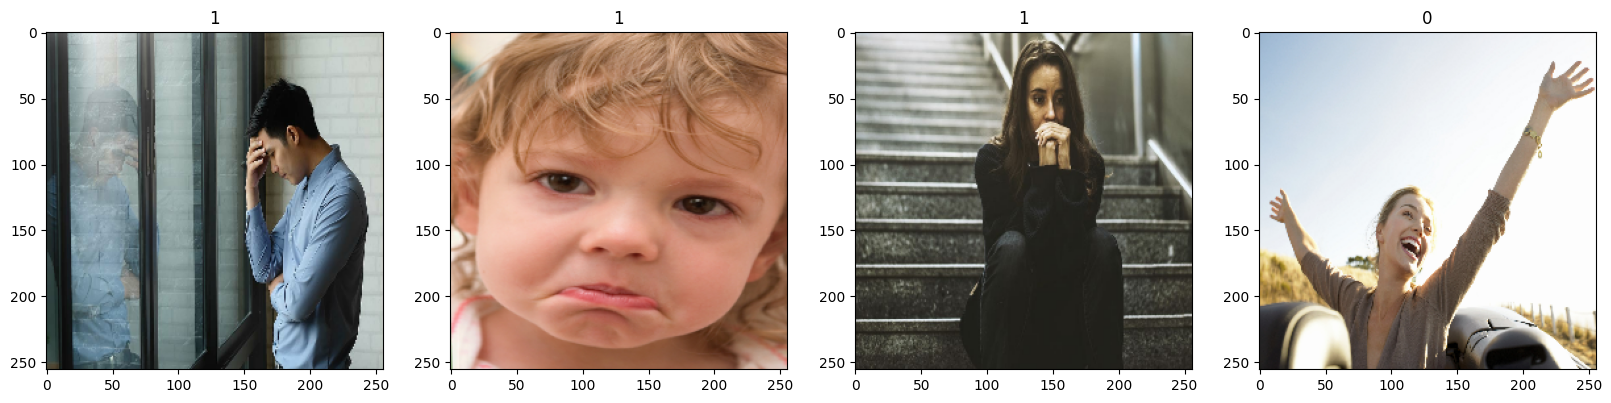

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocess Data

Scale Data

In [86]:
data = data.map(lambda x,y: (x/255, y))

In [87]:
scaled_iterator = data.as_numpy_iterator()

In [88]:
batch = scaled_iterator.next()

In [91]:
batch[0].max()

1.0

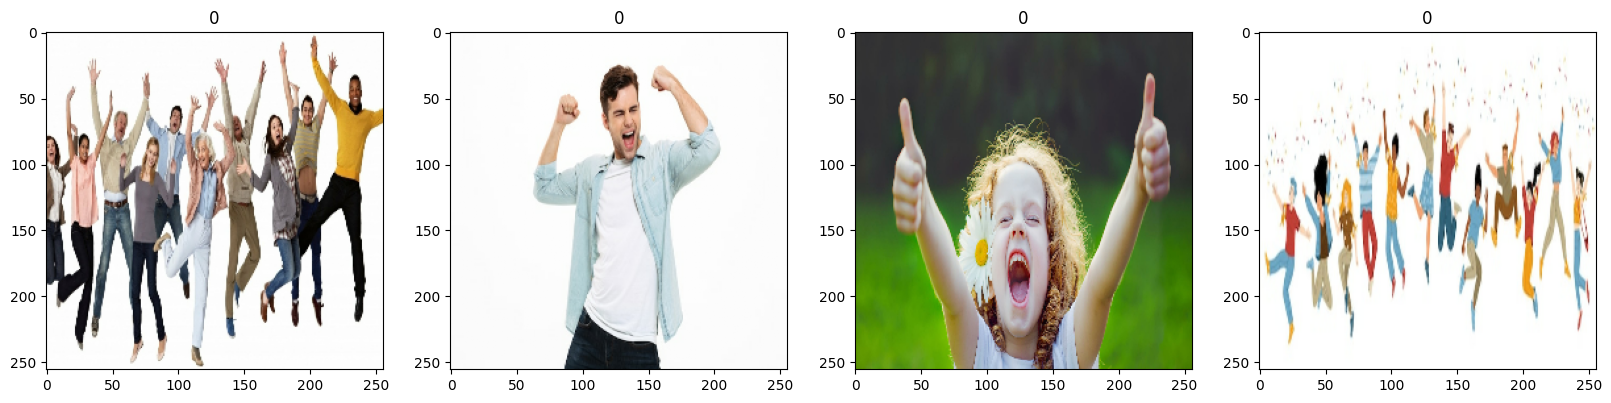

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split data

In [98]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [101]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)